## **Universidad Galileo**
## **Maestría en Data Science**
## **Statistical Learning II**
## **Antonio Everardo Navas Contreras, 14003163**
## **24/09/2021**

---

## **PROYECTO FINAL - CNN**

---

### CARGAR LIBRERÍAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

In [ ]:
pip install yfinance

### CARGAR, PREPARAR Y EXPLORAR LA DATA

In [ ]:
# Descargar data para trabajar

years = 5

end_date = datetime.now()
start_date = datetime(end_date.year - years, end_date.month, end_date.day)

companies = ['MSFT', 'GOOG', 'AMZN']
data = pd.DataFrame(columns = companies)

data = yf.download(tickers = companies, start = start_date, end = end_date, group_by = "ticker")

data.head()

[*********************100%***********************]  3 of 3 completed


MSFT                        ...        AMZN                     
                 Open       High        Low  ...       Close   Adj Close   Volume
Date                                         ...                                 
2016-09-26  57.080002  57.139999  56.830002  ...  799.159973  799.159973  2651400
2016-09-27  56.930000  58.060001  56.680000  ...  816.109985  816.109985  3819600
2016-09-28  57.880001  58.060001  57.669998  ...  828.719971  828.719971  4422100
2016-09-29  57.810001  58.169998  57.209999  ...  829.049988  829.049988  4922200
2016-09-30  57.570000  57.770000  57.340000  ...  837.309998  837.309998  4430600

[5 rows x 18 columns]

In [ ]:
# Estadística descriptiva

data.describe()

MSFT               ...         AMZN              
              Open         High  ...    Adj Close        Volume
count  1259.000000  1259.000000  ...  1259.000000  1.259000e+03
mean    140.401676   141.712237  ...  1944.359950  4.320049e+06
std      66.962299    67.618365  ...   863.750691  2.073632e+06
min      56.700001    57.139999  ...   719.070007  7.669160e+05
25%      85.975002    86.250000  ...  1186.739990  2.917600e+06
50%     118.620003   119.110001  ...  1785.000000  3.718100e+06
75%     198.235001   201.735001  ...  2744.489990  5.118250e+06
max     305.019989   305.839996  ...  3731.409912  1.656500e+07

[8 rows x 18 columns]

In [ ]:
# Ver solo variable Close

data.xs('Close', axis = 1, level = 1, drop_level = True)

,MSFT,GOOG,AMZN
Date,,,
2016-09-26,56.900002,774.210022,799.159973
2016-09-27,57.950001,783.010010,816.109985
2016-09-28,58.029999,781.559998,828.719971
2016-09-29,57.400002,775.010010,829.049988
2016-09-30,57.599998,777.289978,837.309998
...,...,...,...
2021-09-20,294.299988,2780.340088,3355.729980
2021-09-21,294.799988,2792.929932,3343.629883
2021-09-22,298.579987,2818.770020,3380.050049


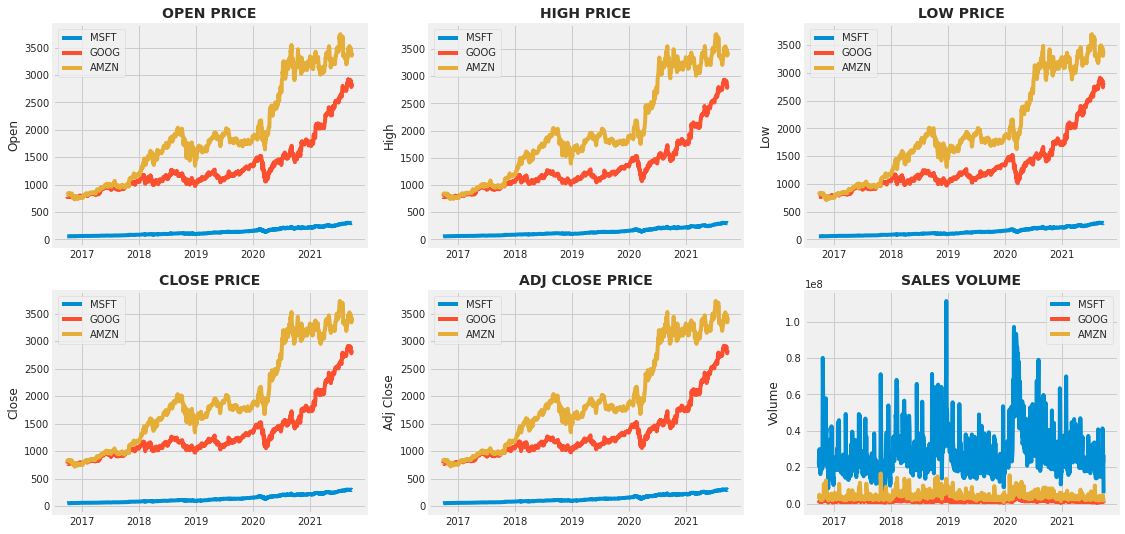

In [ ]:
# Graficar todas las variables para todas las compañias

variables_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
title_list = ['OPEN PRICE', 'HIGH PRICE', 'LOW PRICE', 'CLOSE PRICE', 'ADJ CLOSE PRICE', 'SALES VOLUME']

plt.figure(figsize=(17, 9))

for i, variable in enumerate(variables_list):
  plt.subplot(2, 3, i+1)
  data_var = data.xs(variable, axis = 1, level = 1, drop_level = True)
  plt.plot(data_var)
  plt.ylabel(variable)
  plt.title(title_list[i], fontdict={"fontsize":14, "fontweight":"bold"})
  plt.legend(data_var.columns)
plt.show()

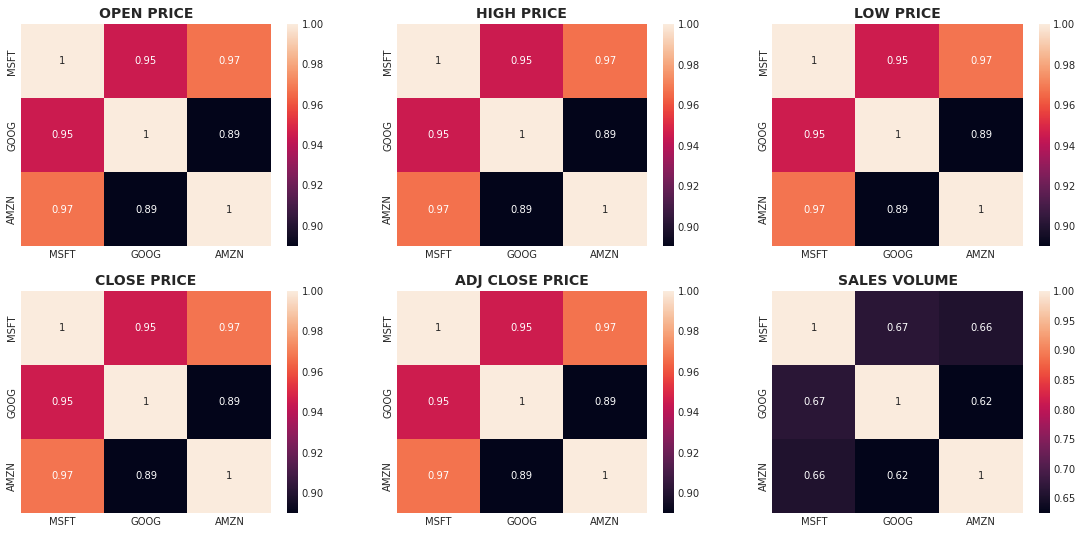

In [ ]:
# Ver la correlación entre variables de las acciones de las compañias

variables_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
title_list = ['OPEN PRICE', 'HIGH PRICE', 'LOW PRICE', 'CLOSE PRICE', 'ADJ CLOSE PRICE', 'SALES VOLUME']

plt.figure(figsize=(17, 9))

for i, variable in enumerate(variables_list):
  plt.subplot(2, 3, i+1)
  corr_matrix = data.xs(variable, axis = 1, level = 1, drop_level = True).corr()
  sns.heatmap(corr_matrix, annot=True)
  plt.title(title_list[i], fontdict={"fontsize":14, "fontweight":"bold"})
plt.show()

In [ ]:
# Normalizar la data
close_data = data.xs('Close', axis = 1, level = 1, drop_level = True)

norm = MinMaxScaler()
#norm = StandardScaler()
norm_data = norm.fit_transform(close_data)

norm_data

array([[0.        , 0.01748473, 0.02658729],
       [0.00422841, 0.02152002, 0.03221415],
       [0.00455057, 0.02085511, 0.03640026],
       ...,
       [0.97326025, 0.95502941, 0.88335982],
       [0.97720682, 0.96317336, 0.89529405],
       [0.96874996, 0.9667134 , 0.88908627]])

In [ ]:
# Dividir el conjunto de datos para entrenamiento y prueba
train_split = 0.8

train_size = int(len(norm_data) * train_split)

train = norm_data[0:train_size, :]
test = norm_data[train_size:len(norm_data), :]

print('Train set:', len(train), 'observaciones')
print('Test set: ', len(test), 'observaciones')

Train set: 1007 observaciones
Test set:  252 observaciones


In [ ]:
# Crear x_train y y_train para AMZN GOOG MSFT

historical = 100

def convertToXY(dataset, historical):
  x_data = []
  y_data = []

  for i in range(len(dataset)-historical):
    x_data.append(dataset[i:i+historical])
    y_data.append(dataset[i+historical])
  
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))
  y_data = y_data.reshape(-1,1)

  return x_data, y_data

In [ ]:
# Train
x_train_MSFT, y_train_MSFT = convertToXY(train[:,2], historical)
x_train_GOOG, y_train_GOOG = convertToXY(train[:,1], historical)
x_train_AMZN, y_train_AMZN = convertToXY(train[:,0], historical)

# Test
x_test_MSFT, y_test_MSFT = convertToXY(test[:,2], historical)
x_test_GOOG, y_test_GOOG = convertToXY(test[:,1], historical)
x_test_AMZN, y_test_AMZN = convertToXY(test[:,0], historical)

In [ ]:
print('--------------------- T R A I N   S E T  ---------------------')
print('MSFT Shape ->', 'x_train:', x_train_MSFT.shape, '| y_train:', y_train_MSFT.shape)
print('GOOG Shape ->', 'x_train:', x_train_GOOG.shape, '| y_train:', y_train_GOOG.shape)
print('AMZN Shape ->', 'x_train:', x_train_AMZN.shape, '| y_train:', y_train_AMZN.shape)
print('\n')
print('--------------------- T E S T   S E T  ---------------------')
print('MSFT Shape ->', 'x_train:', x_test_MSFT.shape, '| y_train:', y_test_MSFT.shape)
print('GOOG Shape ->', 'x_train:', x_test_GOOG.shape, '| y_train:', y_test_GOOG.shape)
print('AMZN Shape ->', 'x_train:', x_test_AMZN.shape, '| y_train:', y_test_AMZN.shape)

--------------------- T R A I N   S E T  ---------------------
MSFT Shape -> x_train: (907, 100, 1) | y_train: (907, 1)
GOOG Shape -> x_train: (907, 100, 1) | y_train: (907, 1)
AMZN Shape -> x_train: (907, 100, 1) | y_train: (907, 1)


--------------------- T E S T   S E T  ---------------------
MSFT Shape -> x_train: (152, 100, 1) | y_train: (152, 1)
GOOG Shape -> x_train: (152, 100, 1) | y_train: (152, 1)
AMZN Shape -> x_train: (152, 100, 1) | y_train: (152, 1)


### CREAR RED Y EXPERIMENTAR

In [ ]:
# Función para crear la RNN, compilarla y entrenarla

def model_LSTM(x_train, y_train, x_test, epochs, company):

  # Chekpoint para guardar los parámetros del mejor Accuracy alcanzado con datos de validación
  checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/RNN/Models/RNN_best_weights_" + company  + ".hdf5",
                               monitor = 'loss',
                               verbose=1,
                               save_best_only=True,)
  
  try:
    model.load_weights("/content/drive/MyDrive/RNN/Models/RNN_best_weights_" + company  + ".hdf5")
  except:
  model = Sequential([
                      LSTM(units=128, input_shape=(historical, 1), return_sequences=True),
                      LSTM(units=64, return_sequences=False),
                      Dense(units=32),
                      Dense(units=1)
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss = 'mean_squared_error')

  history = model.fit(x_train, y_train, batch_size = 1, epochs = epochs, callbacks = [checkpoint])

  y_predict = model.predict(x_test)

  return model, history, y_predict

In [ ]:
epochs = 50

In [ ]:
# Entrenar modelo para MSFT

model_MSFT, history_MSFT, y_predict_MSFT = model_LSTM(x_train_MSFT, y_train_MSFT, x_test_MSFT, epochs, 'MSFT')

Epoch 1/50
907/907 [==============================] - 53s 55ms/step - loss: 9.1266e-04

Epoch 00001: loss improved from inf to 0.00091, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_MSFT.hdf5
Epoch 2/50
907/907 [==============================] - 52s 57ms/step - loss: 3.3698e-04

Epoch 00002: loss improved from 0.00091 to 0.00034, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_MSFT.hdf5
Epoch 3/50
907/907 [==============================] - 49s 54ms/step - loss: 3.2739e-04

Epoch 00003: loss improved from 0.00034 to 0.00033, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_MSFT.hdf5
Epoch 4/50
907/907 [==============================] - 49s 54ms/step - loss: 2.1400e-04

Epoch 00004: loss improved from 0.00033 to 0.00021, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_MSFT.hdf5
Epoch 5/50
907/907 [==============================] - 49s 55ms/step - loss: 2.1224e-04

Epoch 00005: loss improved from 0.00021 to 0.000

In [ ]:
# Entrenar modelo para GOOG

model_GOOG, history_GOOG, y_predict_GOOG = model_LSTM(x_train_GOOG, y_train_GOOG, x_test_GOOG, epochs, 'GOOG')

Epoch 1/50
907/907 [==============================] - 54s 56ms/step - loss: 0.0016

Epoch 00001: loss improved from inf to 0.00163, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_GOOG.hdf5
Epoch 2/50
907/907 [==============================] - 53s 58ms/step - loss: 6.0891e-04

Epoch 00002: loss improved from 0.00163 to 0.00061, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_GOOG.hdf5
Epoch 3/50
907/907 [==============================] - 52s 58ms/step - loss: 4.9337e-04

Epoch 00003: loss improved from 0.00061 to 0.00049, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_GOOG.hdf5
Epoch 4/50
907/907 [==============================] - 53s 58ms/step - loss: 3.7656e-04

Epoch 00004: loss improved from 0.00049 to 0.00038, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_GOOG.hdf5
Epoch 5/50
907/907 [==============================] - 54s 59ms/step - loss: 4.5580e-04

Epoch 00005: loss did not improve from 0.00038
Epoch

In [ ]:
# Entrenar modelo para AMZN

model_AMZN, history_AMZN, y_predict_AMZN = model_LSTM(x_train_AMZN, y_train_AMZN, x_test_AMZN, epochs, 'AMZN')

Epoch 1/50
907/907 [==============================] - 54s 56ms/step - loss: 0.0024

Epoch 00001: loss improved from inf to 0.00239, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_AMZN.hdf5
Epoch 2/50
907/907 [==============================] - 50s 55ms/step - loss: 7.3836e-04

Epoch 00002: loss improved from 0.00239 to 0.00074, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_AMZN.hdf5
Epoch 3/50
907/907 [==============================] - 50s 55ms/step - loss: 6.5140e-04

Epoch 00003: loss improved from 0.00074 to 0.00065, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_AMZN.hdf5
Epoch 4/50
907/907 [==============================] - 49s 54ms/step - loss: 5.3311e-04

Epoch 00004: loss improved from 0.00065 to 0.00053, saving model to /content/drive/MyDrive/RNN/Models/RNN_best_weights_AMZN.hdf5
Epoch 5/50
907/907 [==============================] - 50s 55ms/step - loss: 5.4889e-04

Epoch 00005: loss did not improve from 0.00053
Epoch

In [ ]:
# Guardar el modelo final

model_MSFT.save('/content/drive/MyDrive/RNN/Models/RNN_best_weights_MSFT.h5')
model_GOOG.save('/content/drive/MyDrive/RNN/Models/RNN_best_weights_GOOG.h5')
model_AMZN.save('/content/drive/MyDrive/RNN/Models/RNN_best_weights_AMZN.h5')

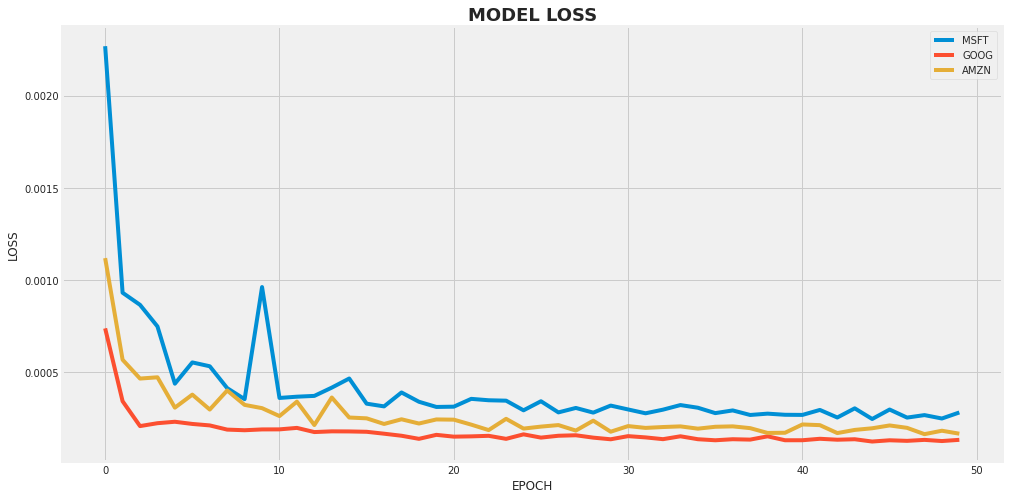

In [ ]:
# Gráfica de LOSS

plt.figure(figsize=(15, 8))

plt.plot(history_MSFT.history['loss'], label='MSFT')
plt.plot(history_GOOG.history['loss'], label='GOOG')
plt.plot(history_AMZN.history['loss'], label='AMZN')
plt.title('MODEL LOSS', fontdict={"fontsize":18, "fontweight":"bold"})
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend()
plt.show()

In [ ]:
# Inversa de los datos normalizados

preds_array = np.concatenate((y_predict_MSFT, y_predict_GOOG, y_predict_AMZN), axis=1)
inv_preds_array = norm.inverse_transform(preds_array)

In [ ]:
# RMSE por compañia
rmse = np.sqrt(np.mean(((inv_preds_array[:,0] - y_test_MSFT) ** 2)))
print('MSFT RMSE:', np.round(rmse, 2))

rmse = np.sqrt(np.mean(((inv_preds_array[:,1] - y_test_GOOG) ** 2)))
print('GOOG RMSE:', np.round(rmse, 2))

rmse = np.sqrt(np.mean(((inv_preds_array[:,2] - y_test_AMZN) ** 2)))
print('AMZN RMSE:', np.round(rmse, 2))


MSFT RMSE: 271.14
GOOG RMSE: 2254.5
AMZN RMSE: 3122.09


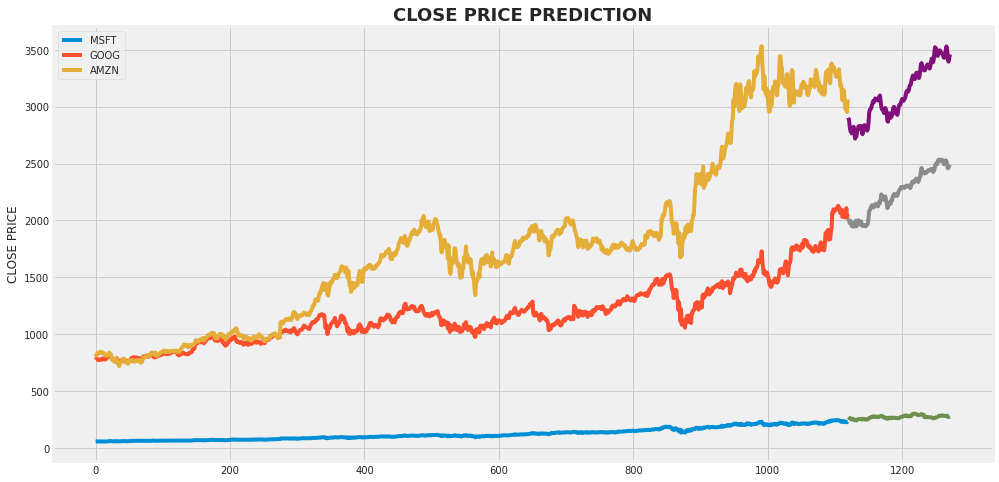

In [ ]:
# Gráfica de predicción

plt.figure(figsize=(15, 8))

historic_data = pd.DataFrame(norm.inverse_transform(norm_data[:1120,]), columns=['MSFT', 'GOOG', 'AMZN'])
predicted_data = pd.DataFrame(inv_preds_array, columns=['MSFT', 'GOOG', 'AMZN'])

plt.plot(historic_data)
x_axis = range(len(historic_data), len(historic_data) + len(predicted_data))
plt.plot(x_axis[:], predicted_data)
plt.title('CLOSE PRICE PREDICTION', fontdict={"fontsize":18, "fontweight":"bold"})
plt.ylabel('CLOSE PRICE')
plt.legend(historic_data.columns)
plt.show()

### CONCLUSIONES

* Se realizó un análisis exploratorio de distintas variables para las acciones de 3 compañías que cotizan en bolsa, y se creó una red neuronal recurrente para analizar los datos históricos de 5 años y poder predecir el precio de cierre de las acciones, por un período de 1 año a partir de la fecha actual en que se realice el análisis.

* Mientras mas tiempo hacia atras se tenga de data histórica, podrá realizarse una mejor tendencia y mejor predicción.

* Se puede observar que la red RNN, se puede modelar como aprendizaje supervisado transformando los datos a una forma estructurada.